# ARIMA model for XRP forecasting

## Libraries


Pandas, Numpy, statsmodel and matplotlib libraries are imported.

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import pandas as df
import pandas as pnd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm




## Data Exploration - XRP/USD 


Plots are generated for the total data as well as for the selected data set.

--------------- Original Dataset ---------------
                           unix   symbol     open     high      low    close  \
date                                                                           
2022-11-18 00:00:00  1668729600  XRP/USD  0.38148  0.38767  0.38128  0.38330   
2022-11-17 23:00:00  1668726000  XRP/USD  0.38360  0.38411  0.38051  0.38142   
2022-11-17 22:00:00  1668722400  XRP/USD  0.38314  0.38458  0.38147  0.38377   
2022-11-17 21:00:00  1668718800  XRP/USD  0.38229  0.38421  0.38138  0.38245   
2022-11-17 20:00:00  1668715200  XRP/USD  0.38038  0.38457  0.38027  0.38243   
...                         ...      ...      ...      ...      ...      ...   
2018-05-15 10:00:00  1526378400  XRP/USD  0.73300  0.74850  0.73000  0.74090   
2018-05-15 09:00:00  1526374800  XRP/USD  0.73600  0.73750  0.73300  0.73300   
2018-05-15 08:00:00  1526371200  XRP/USD  0.74060  0.74070  0.73000  0.73600   
2018-05-15 07:00:00  1526367600  XRP/USD  0.74190  0.74600  0.73900  0.

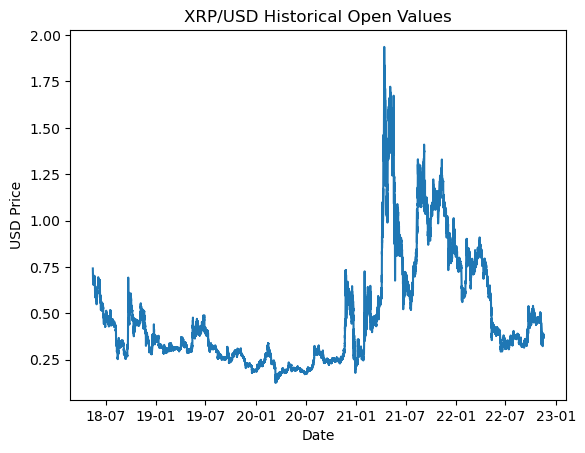



--------------- Selected Open values (Pandemic times) ---------------
                        open
date                        
2022-11-18 00:00:00  0.38148
2022-11-17 23:00:00  0.38360
2022-11-17 22:00:00  0.38314
2022-11-17 21:00:00  0.38229
2022-11-17 20:00:00  0.38038
...                      ...
2020-10-29 05:00:00  0.24587
2020-10-29 04:00:00  0.24691
2020-10-29 03:00:00  0.24547
2020-10-29 02:00:00  0.24608
2020-10-29 01:00:00  0.24515

[18000 rows x 1 columns]
Total samples XRP/USD: 18000


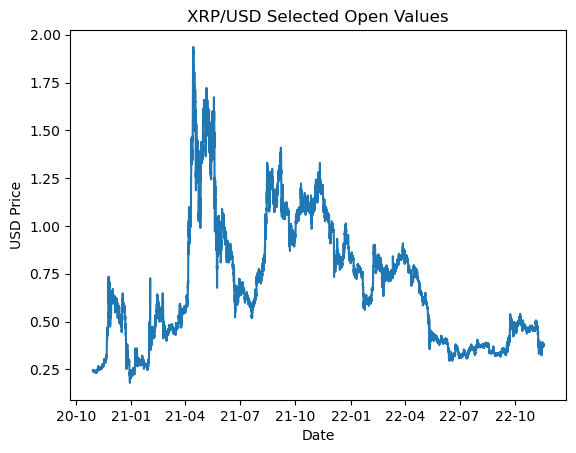

In [3]:
date_form = DateFormatter("%y-%m")
xrp = pnd.read_csv('Bitstamp_XRPUSD_1h.csv', sep=',', header=1, index_col=1, parse_dates=True)

print("--------------- Original Dataset ---------------")
print(xrp)
print(f"Total samples XRP/USD: {len(xrp)}")
print(xrp.shape)

xrp_open = pd.DataFrame(xrp, columns=["open"])
samples_number = 18000

fig, ax = plt.subplots()
plt.plot(xrp_open)
plt.title('XRP/USD Historical Open Values')
ax.xaxis.set_major_formatter(date_form)
plt.ylabel('USD Price')
plt.xlabel('Date')
plt.show()

print("")
print("")
print("--------------- Selected Open values (Pandemic times) ---------------")

xrp_open = xrp_open.iloc[0:samples_number]

print(xrp_open)
print(f"Total samples XRP/USD: {len(xrp_open)}")

fig, ax = plt.subplots()
plt.plot(xrp_open)
plt.title('XRP/USD Selected Open Values')
ax.xaxis.set_major_formatter(date_form)
plt.ylabel('USD Price')
plt.xlabel('Date')
plt.show()



Graphs are made by month, by three months, by two weeks and daily. 

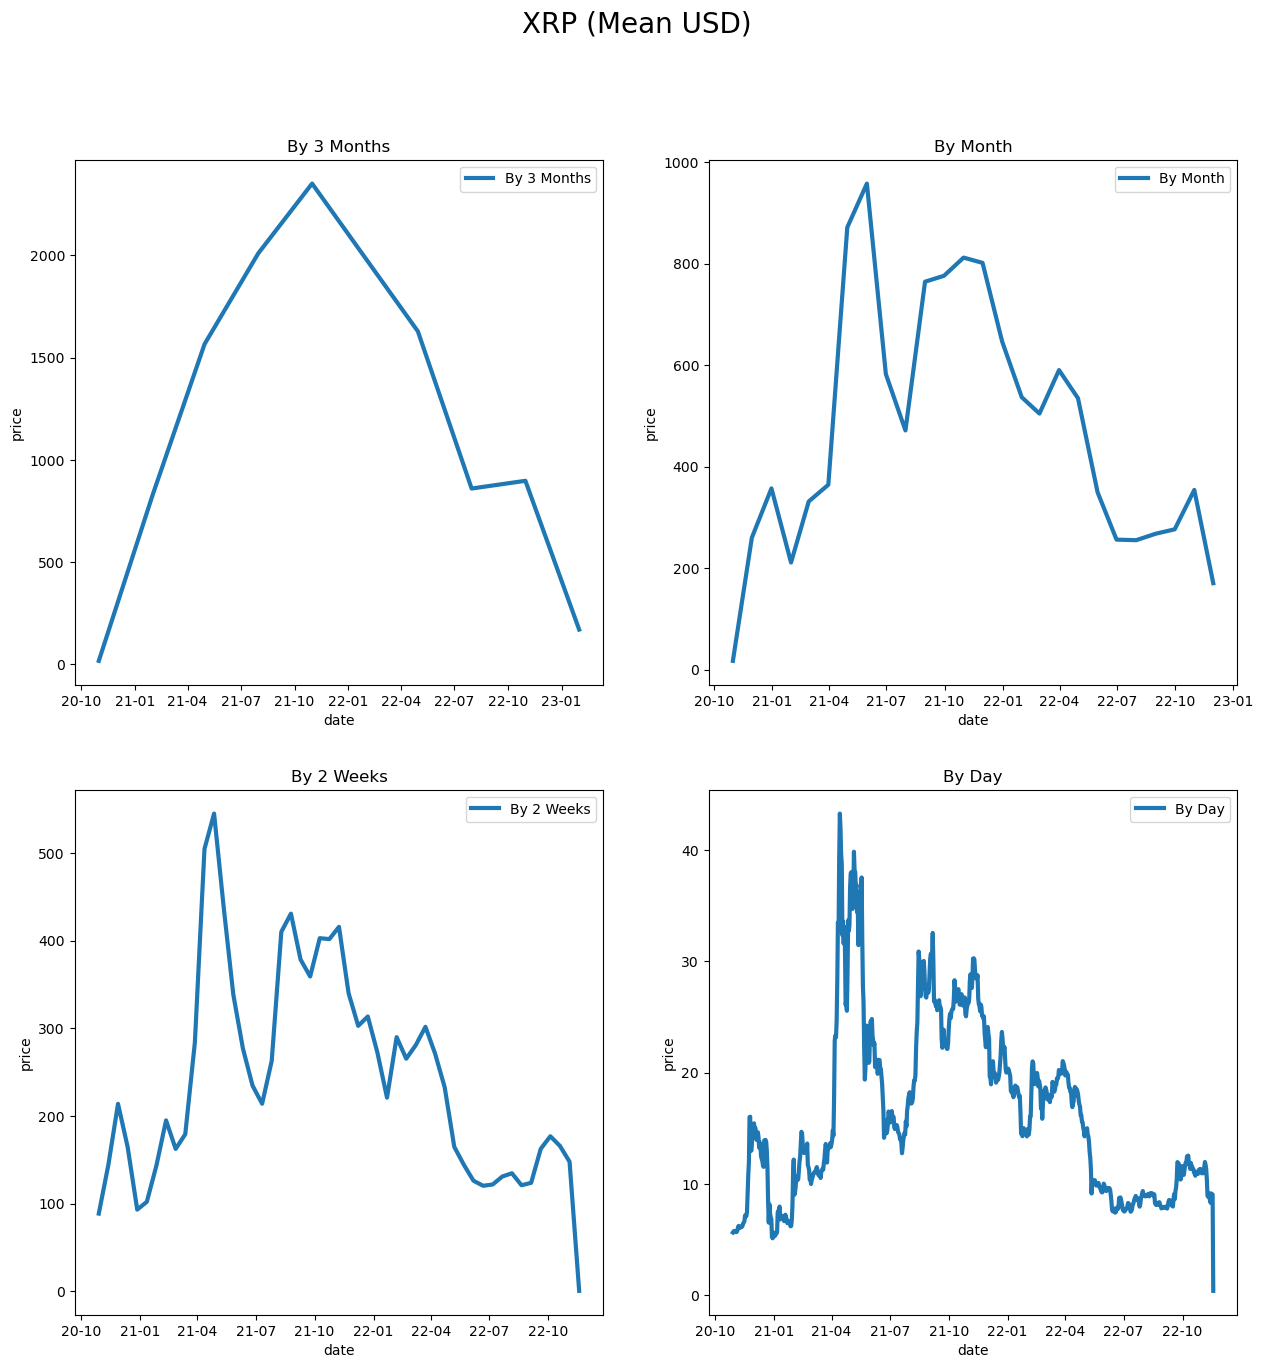

In [4]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,15)

fig.suptitle('XRP (Mean USD)', fontsize=20)
ax[0,0].plot(xrp_open.resample('3M').sum(),'-', label='By 3 Months', linewidth = 3)
ax[0,1].plot(xrp_open.resample('1M').sum(),'-', label='By Month', linewidth = 3)
ax[1,0].plot(xrp_open.resample('15D').sum(),'-', label='By 2 Weeks', linewidth = 3)
ax[1,1].plot(xrp_open.resample('1D').sum(),'-', label='By Day', linewidth = 3)
ax[0,0].legend()
ax[0,1].legend()
ax[1,1].legend()
ax[1,0].legend()

ax[0,0].set_title('By 3 Months')
ax[0,0].xaxis.set_major_formatter(date_form)
ax[0,0].set_xlabel('date')
ax[0,0].set_ylabel('price')
ax[0,0].ticklabel_format(style='plain', axis='y', useMathText=False)

ax[0,1].set_title('By Month')
ax[0,1].xaxis.set_major_formatter(date_form)
ax[0,1].set_xlabel('date')
ax[0,1].set_ylabel('price')
ax[0,1].ticklabel_format(style='plain', axis='y', useMathText=False)

ax[1,0].set_title('By 2 Weeks')
ax[1,0].xaxis.set_major_formatter(date_form)
ax[1,0].set_xlabel('date')
ax[1,0].set_ylabel('price')
ax[1,0].ticklabel_format(style='plain', axis='y', useMathText=False)


ax[1,1].set_title('By Day')
ax[1,1].xaxis.set_major_formatter(date_form)
ax[1,1].set_xlabel('date')
ax[1,1].set_ylabel('price')
ax[1,1].ticklabel_format(style='plain', axis='y', useMathText=False)

Based on this, it is decided that the daily signal will be predicted.

## Data Pre-Processing

### Stationarity check and STL-decomposition of the series

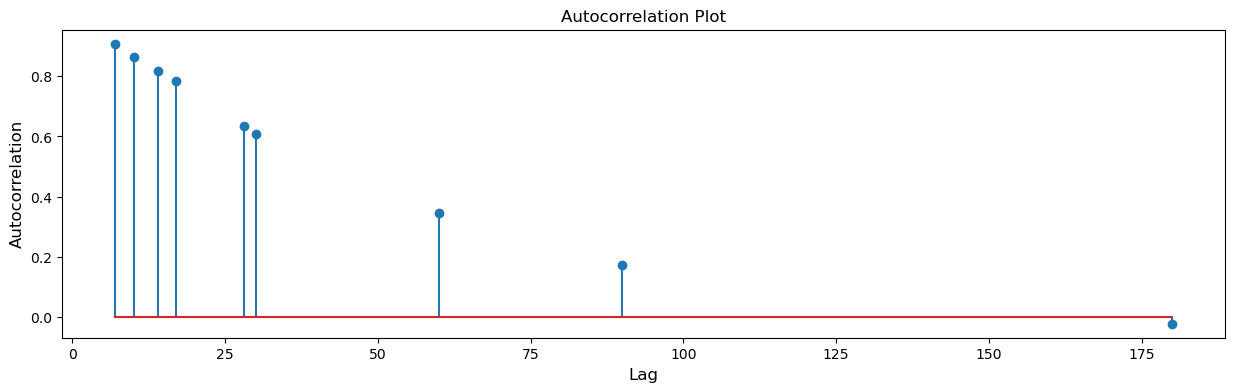

In [5]:
xrp_open_day = xrp_open.resample('1D').sum()

lags = [7, 10, 14, 17, 28, 30, 60, 90, 180] 
autocorrs = [xrp_open_day.open.autocorr(lag=lag) for lag in lags]
plt.figure(figsize=(15, 4))
plt.stem(lags, autocorrs)
plt.title("Autocorrelation Plot")
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.show()

According to the chart above, the highest correlation occurs with a lag of 7, meaning that the data repeats a pattern on a weekly basis. This is somewhat true for the Cryptocurrencies price, as from experience it has been seen that the price tends to have a similar behavior every week due to the periodicity of the markets and the actions of those involved. 


Another way of checking the autocorrelation is through Pandas tools library. Running that we can see positive correlation for the first 100 lags with the most significant ones being the first 10 ones.



--------------- Autocorrelation Plot---------------


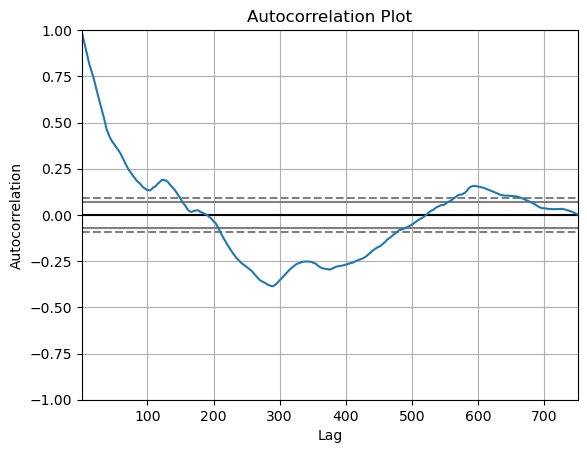

In [6]:
from pandas.plotting import autocorrelation_plot
print("")
print("")
print("--------------- Autocorrelation Plot---------------")

autocorrelation_plot(xrp_open_day)
plt.title("Autocorrelation Plot")
plt.show()


Using Seasonal decompose

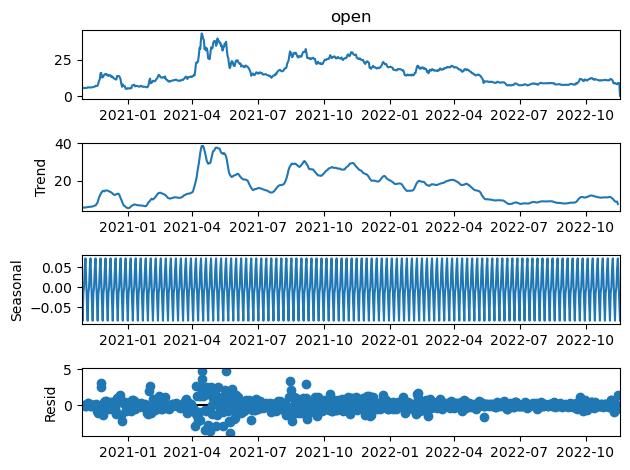

--------------- Dickey–Fuller test ---------------
p=0.285552


In [7]:
sm.tsa.seasonal_decompose(xrp_open_day.open).plot()
plt.rcParams["figure.figsize"] = (15,10)
plt.show()
print("--------------- Dickey–Fuller test ---------------")
print("p=%f" % sm.tsa.stattools.adfuller(xrp_open_day.open)[1])



The series are not stationary based on the results of the Dickey-Fuller test.

### Box Cox Transformation


A Box Cox transformation is a transformation of non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

In [8]:
xrp_open_day_bc = xrp_open_day['open']
xrp_open_day_bc['open'], lmbda = stats.boxcox(xrp_open_day.open)
print("--------------- Dickey–Fuller test ---------------")
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(xrp_open_day_bc.open)[1])


--------------- Dickey–Fuller test ---------------
Dickey–Fuller test: p=0.864131


Series are not stationary

### Seasonal Differentiation

In [9]:
# Seasonal differentiation
xrp_open_day_sd = xrp_open_day
xrp_open_day_sd['open'] = xrp_open_day_bc - xrp_open_day_bc.shift(7)
print("--------------- Dickey–Fuller test ---------------")
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(xrp_open_day_sd.open[7:])[1])

--------------- Dickey–Fuller test ---------------
Dickey–Fuller test: p=0.000004


Series are now stationary

### Seasonal decompose

<Figure size 16000x3000 with 0 Axes>

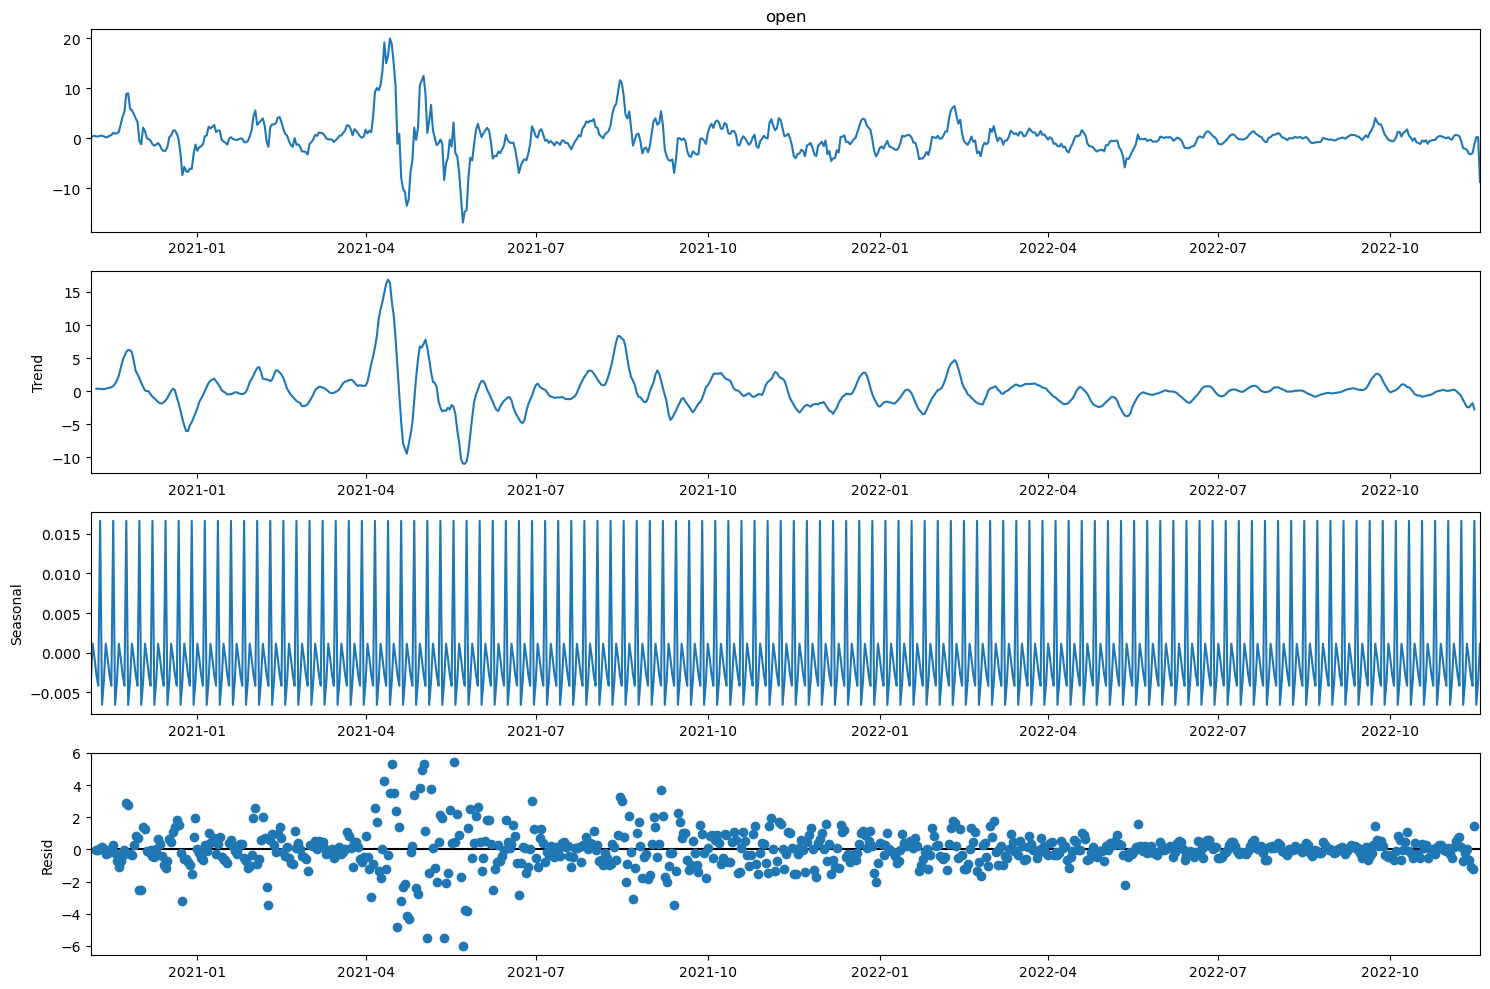

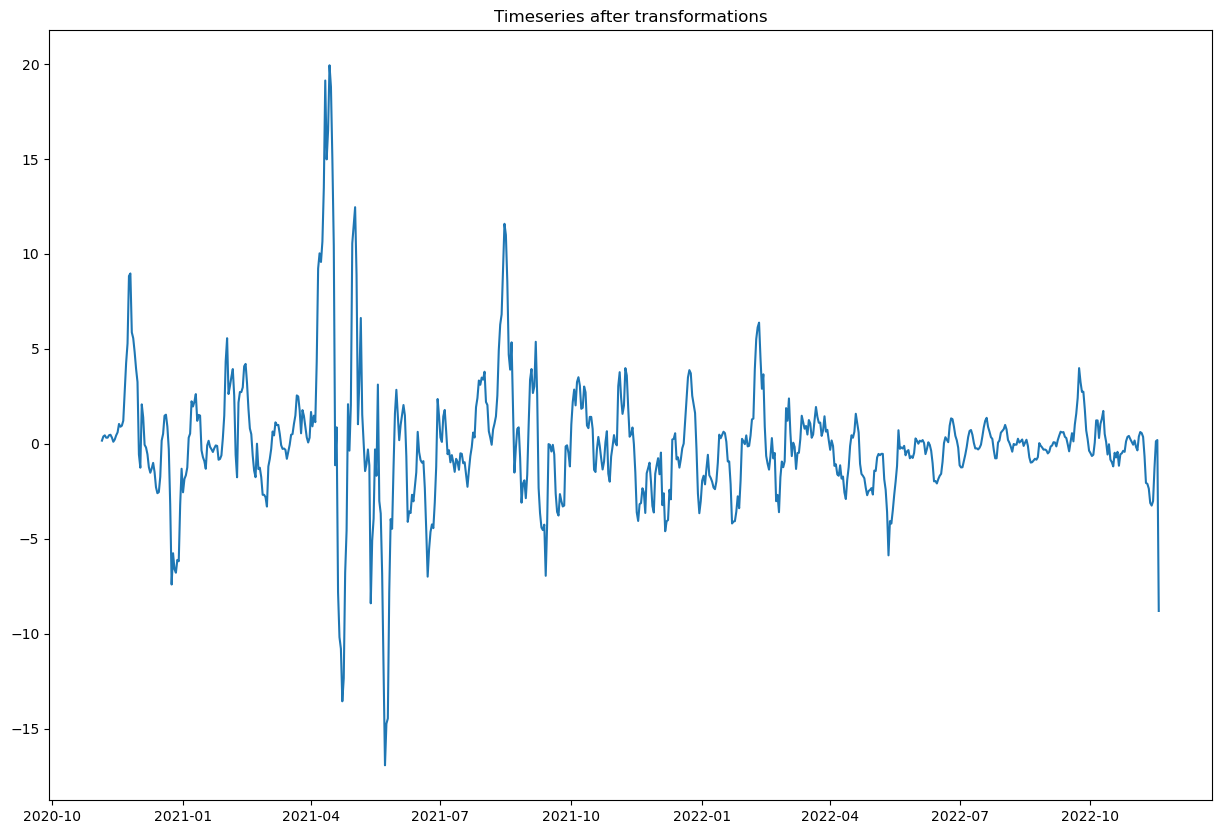

In [10]:
plt.figure(figsize=(160,30))
sm.tsa.seasonal_decompose(xrp_open_day_sd.open[7:]).plot()
plt.rcParams["figure.figsize"] = (15,10)
plt.show()
plt.figure()
plt.title("Timeseries after transformations")
plt.plot(xrp_open_day_sd)

### Split training and validation set

the data set will be divided where 90% of the data was used for training and 10% will be used for validation.

In [11]:
xrp_open_day_sd = xrp_open_day_sd.dropna()
size = int(len(xrp_open_day_sd) * 0.90)
X = xrp_open_day_sd
train, test = X[0:size], X[size:len(X)]

print("")
print("")
print("--------------- Train Set ---------------")
print(train)
print("")
print("")
print("--------------- Validation Set ---------------")
print(test)





--------------- Train Set ---------------
               open
date               
2020-11-05  0.16948
2020-11-06  0.38987
2020-11-07  0.44916
2020-11-08  0.32519
2020-11-09  0.32631
...             ...
2022-08-31 -0.34281
2022-09-01  -0.5033
2022-09-02 -0.41879
2022-09-03 -0.13977
2022-09-04 -0.08802

[669 rows x 1 columns]


--------------- Validation Set ---------------
               open
date               
2022-09-05  0.08597
2022-09-06  0.07338
2022-09-07 -0.13395
2022-09-08  0.19548
2022-09-09  0.43064
...             ...
2022-11-14 -3.01625
2022-11-15 -1.27162
2022-11-16  0.13866
2022-11-17  0.20097
2022-11-18 -8.79699

[75 rows x 1 columns]


## AUTO_ARIMA Parameter Tunning




The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima.

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

In [12]:
# Fit models

model_fit = pm.auto_arima(train, start_p = 1, max_p = 8, start_q = 1, max_q = 8, 
                          max_d = 8, n_fits = 5, start_P = 0, 
                          start_Q = 0, max_P = 8, max_Q = 8, max_D = 8, 
                          trace=True, random = True)


print("")
print("")
print("--------------- Model Summary ---------------")

print(model_fit.summary())





Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2461.820, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3588.263, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2489.239, Time=0.06 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3023.324, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3586.291, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2431.056, Time=0.18 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2454.226, Time=0.08 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2433.031, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2433.022, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2456.163, Time=0.11 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2447.505, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2428.842, Time=0.42 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2424.957, Time=0.29 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2454.584, Time=0.28 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=2337.270, Time=1.12 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=2366.112, Time=0.95 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec


/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=2356.681, Time=0.86 sec
 ARIMA(3,0,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.56 sec

Best model:  ARIMA(2,0,4)(0,0,0)[0] intercept
Total fit time: 10.721 seconds


--------------- Model Summary ---------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  669
Model:               SARIMAX(2, 0, 4)   Log Likelihood               -1160.635
Date:                Sun, 29 Jan 2023   AIC                           2337.270
Time:                        13:39:17   BIC                           2373.316
Sample:                    11-05-2020   HQIC                          2351.233
                         - 09-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|

## ARIMA Training and Prediction

taking into account the results obtained for the optimal parameters, these parameters will be used to make the prediction and evaluation of the final model.  Best model:  ARIMA(1,1,2)

In [13]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


#print(train.values)
history = [x for x in train.values.astype(float)] #[x for x in train.values]
testList = test.values.astype(float)
predictions = list()
for t in range(len(testList)):
 model = ARIMA(history, order=(8,3,8)) #Based on the results of auto_arima lib
 model_fit = model.fit()
 output = model_fit.forecast()
 predictions.append(output[0])
 obs = testList[t]
 history.append(obs)
 print("Prediction # : " + str(t))



/Users/jeisonroa/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prediction # : 0
Prediction # : 1
Prediction # : 2
Prediction # : 3
Prediction # : 4
Prediction # : 5
Prediction # : 6
Prediction # : 7
Prediction # : 8
Prediction # : 9
Prediction # : 10
Prediction # : 11
Prediction # : 12
Prediction # : 13
Prediction # : 14
Prediction # : 15
Prediction # : 16
Prediction # : 17
Prediction # : 18
Prediction # : 19
Prediction # : 20
Prediction # : 21
Prediction # : 22
Prediction # : 23
Prediction # : 24
Prediction # : 25
Prediction # : 26
Prediction # : 27
Prediction # : 28
Prediction # : 29
Prediction # : 30
Prediction # : 31
Prediction # : 32
Prediction # : 33
Prediction # : 34
Prediction # : 35
Prediction # : 36
Prediction # : 37
Prediction # : 38
Prediction # : 39
Prediction # : 40
Prediction # : 41
Prediction # : 42
Prediction # : 43
Prediction # : 44
Prediction # : 45
Prediction # : 46
Prediction # : 47
Prediction # : 48
Prediction # : 49
Prediction # : 50
Prediction # : 51
Prediction # : 52
Prediction # : 53
Prediction # : 54
Prediction # : 55
Pr

## Model Summary

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  743
Model:                 ARIMA(8, 3, 8)   Log Likelihood               -1168.281
Date:                Sun, 29 Jan 2023   AIC                           2370.562
Time:                        13:42:16   BIC                           2448.875
Sample:                             0   HQIC                          2400.757
                                - 743                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6743      0.038    -17.956      0.000      -0.748      -0.601
ar.L2         -0.7591      0.049    -15.500      0.000      -0.855      -0.663
ar.L3         -0.6858      0.063    -10.959      0.0

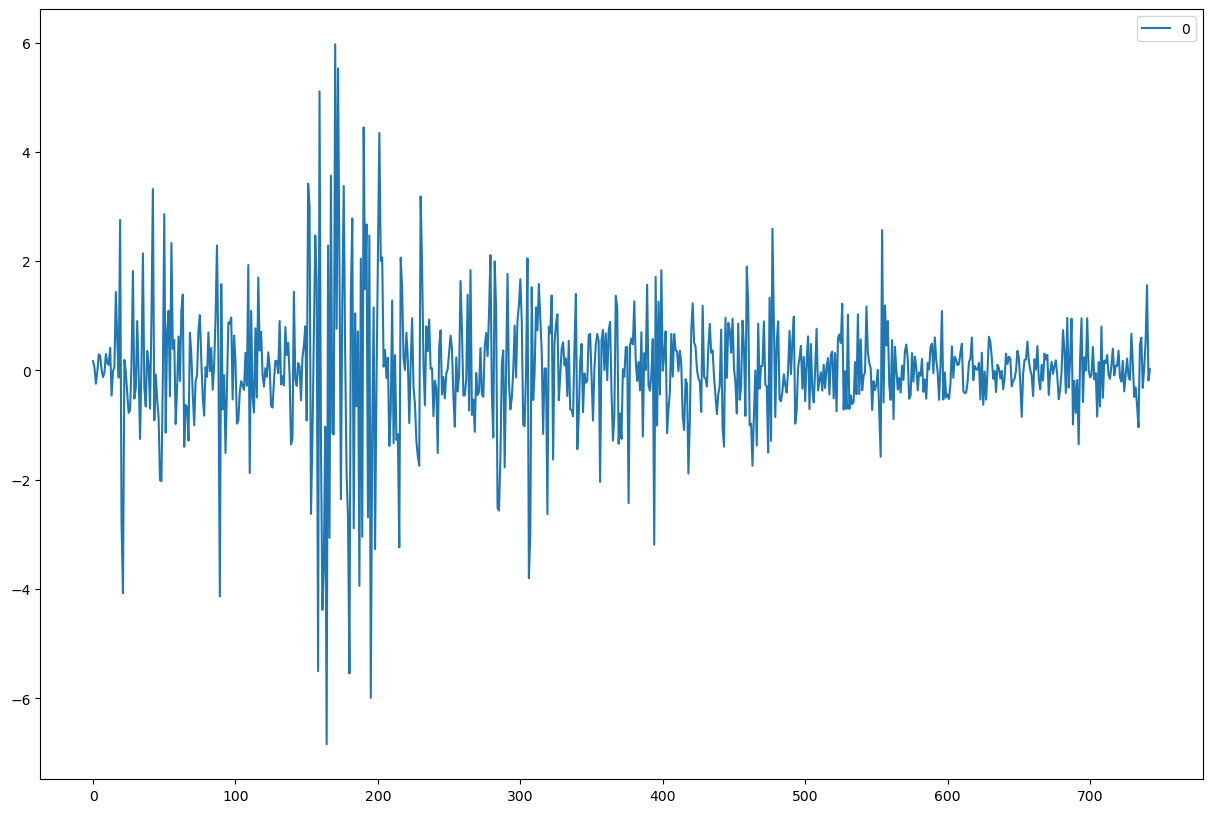



--------------- Residual Density ---------------


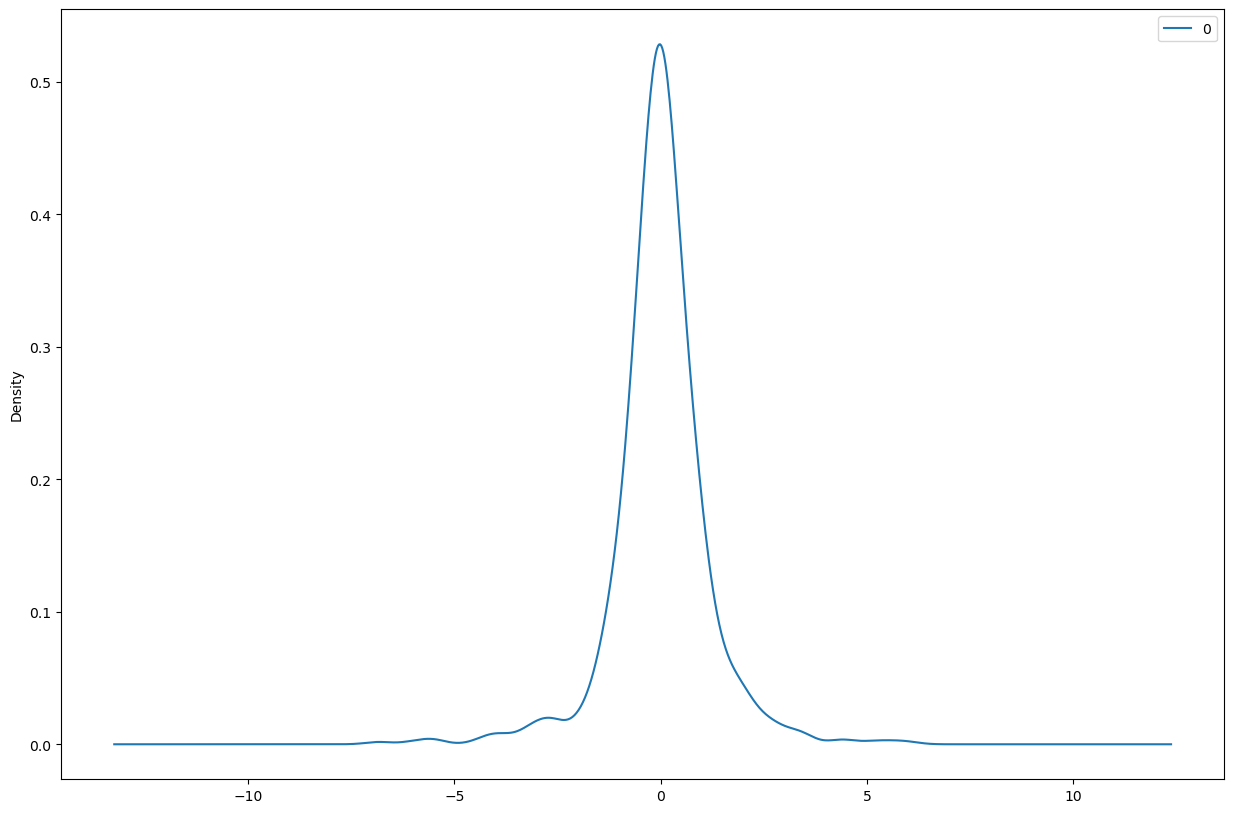



--------------- Residuals Summary ---------------
                0
count  743.000000
mean     0.003417
std      1.171090
min     -6.841692
25%     -0.454792
50%     -0.001491
75%      0.480603
max      5.968516


In [14]:
 print(model_fit.summary())
 
 # Residuals plot
print("")
print("")
print("--------------- Residuals Plot ---------------")
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
print("")
print("")
print("--------------- Residual Density ---------------")
residuals.plot(kind='kde')
pyplot.show()

# summary stats of residuals
print("")
print("")
print("--------------- Residuals Summary ---------------")
print(residuals.describe())


## Performance Evaluation

{'corr': array([[1.        , 0.73937115],
       [0.73937115, 1.        ]]),
 'mae': 0.4807602517365037,
 'mape': 1.7798782140720077,
 'mpe': -0.04519985666682613,
 'rmse': 1.1191986950500834}


Text(0.5, 0, 'Date')

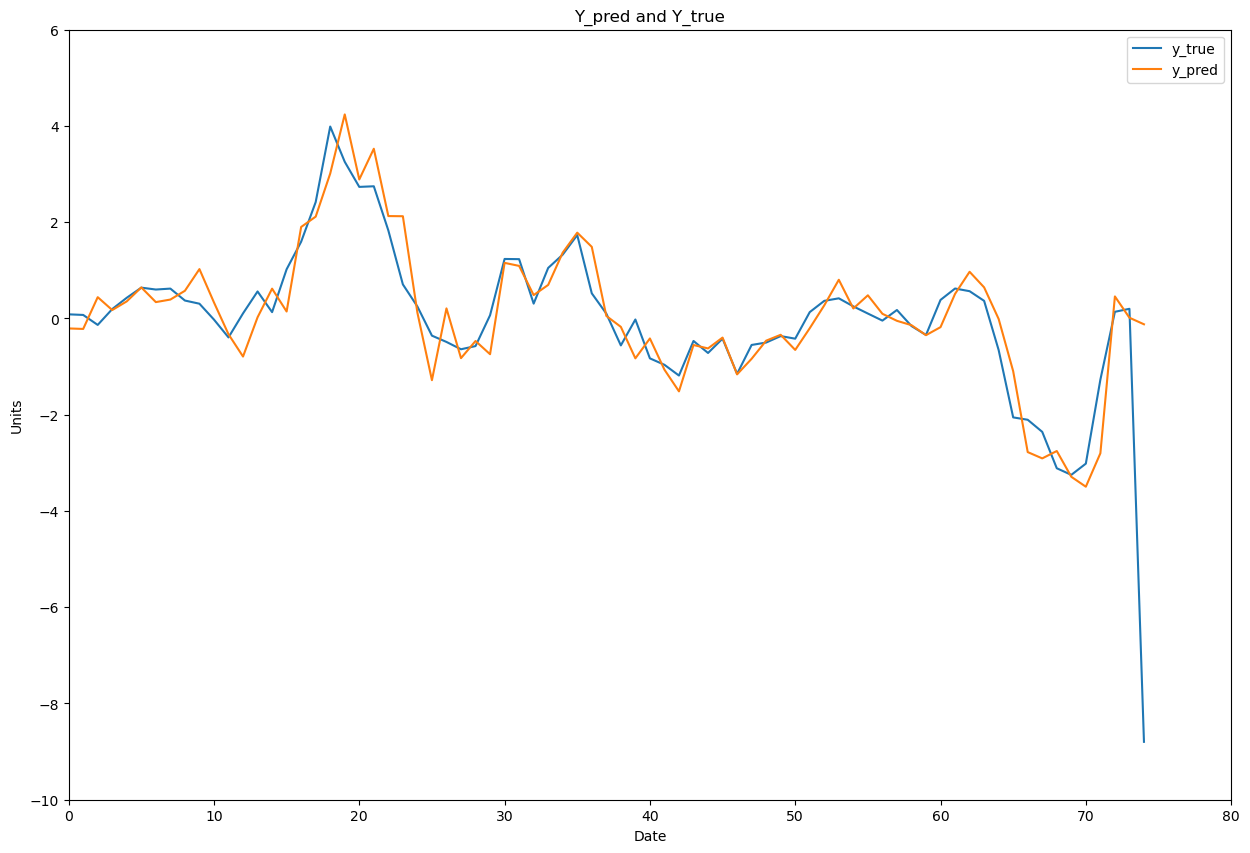

In [15]:
import pprint

y_pred = np.array(predictions)
y_true = np.array(test.open.values.astype(float))

# Mean absolute percentage error
mape = np.mean (np.abs (y_pred - y_true)/np.abs (y_true)) 
# Mean absolute error
mae = np.mean(np.abs (y_pred - y_true))
# Mean percentage error
mpe = np.mean( (y_pred - y_true)/y_true)
# RMSE
rmse = np.mean ( (y_pred - y_true)**2)**.5 
# Correlation Coefficient
corr = np.corrcoef(y_pred, y_true)


pprint.pprint({'mape' :mape, 
                'mae': mae,
                'mpe' : mpe,
                'rmse' :rmse,
                'corr': corr})

plt.figure()
plt.plot(y_true, label='y_true')
plt.plot(y_pred, label='y_pred')
plt.axis([0, 80, -10, 6])
plt.title('Y_pred and Y_true')
plt.legend()
plt.ylabel('Units')
plt.xlabel('Date')





In [16]:
print(y_true)

[ 0.08597  0.07338 -0.13395  0.19548  0.43064  0.64053  0.60127  0.62061
  0.37261  0.3068  -0.02311 -0.39341  0.1058   0.56131  0.13141  1.02239
  1.59524  2.41833  3.98821  3.2554   2.73401  2.74691  1.82898  0.70798
  0.2482  -0.35703 -0.48761 -0.63977 -0.57375  0.06681  1.23659  1.23256
  0.3084   1.05016  1.32675  1.73274  0.52256  0.10155 -0.55985 -0.0212
 -0.82895 -0.96251 -1.18615 -0.46728 -0.7169  -0.41927 -1.15127 -0.55025
 -0.5003  -0.3661  -0.41984  0.13228  0.36604  0.41868  0.25098  0.10227
 -0.04428  0.17596 -0.15731 -0.34275  0.38559  0.62244  0.56678  0.36596
 -0.65633 -2.0555  -2.10473 -2.35639 -3.11246 -3.24967 -3.01625 -1.27162
  0.13866  0.20097 -8.79699]


## References


 Docs: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd


https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
OTher reference https://www.projectpro.io/article/how-to-build-arima-model-in-python/544
